In [2]:
from utils import *
from Kpca import kPCA
from pca import PCA
from utils import param_heatmap, param_scatter, decision_boundary_plot, ROC_curve, check_d

import pandas as pd
import numpy as np
from numpy import random
from sklearn import metrics
import matplotlib.pyplot as plt
from pyod.models.ocsvm import OCSVM
from scipy.linalg import eigh
from sklearn.datasets import fetch_openml
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import resize
from keras.datasets import mnist
methods = ['kPCA','PCA','ParzenWindow','OCSVM']


C:\Users\vahed\AppData\Local\Temp\ipykernel_32752\129353479.py:14: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [3]:
def Cancer_dataset():
    """
    Quoting Hoffman:
        
    The breast-cancer data were obtained from the UCI machine-learning 
    repository [18]. These data were collected by Dr. William H. Wolberg 
    at the University of Wisconsin Hospitals in Madison [19]. The patterns
    in this data set belong to two classes: benign and malignant. 
    Each pattern consists of nine cytological characteristics such as,
    for example, the uniformity of cell size. Each of these characteristics
    is graded with an integer value from 1 to 10, with 1 being typical benign. 
    The database contains some patterns with missing attributes, these 
    patterns were removed before further processing. The remaining patterns
    were scaled to have unit variance in each dimension. To avoid numerical 
    errors because of the discrete values, a uniform noise from the interval 
    [−0.05,0.05] was added to each value. The novelty detectors were trained 
    on the ﬁrst 200 benign samples. The remaining samples were used 
    for testing: 244 benign and 239 malignant.
    """
    n_bg_train = 200
    U = 0.05
    directory = 'test sets/'
    contents = np.genfromtxt(directory+"cancer.csv", delimiter=',')
    data = contents[:,0:-1]
    data = data + np.random.uniform(-U,U,size = data.shape)
    std = np.repeat(np.expand_dims(np.std(data,axis=0),axis=0),data.shape[0],axis=0)
    data = (data)*1/std


    labels = contents[:,-1]

    an_idx = np.where(labels == 1)[0]
    bg_idx = np.where(labels == 0)[0]

    x_train = data[bg_idx[:n_bg_train]]
    x_bg_test = data[bg_idx[n_bg_train:]]
    x_an_test = data[an_idx]

    y_test = np.zeros((x_bg_test.shape[0]+x_an_test.shape[0]))
    y_test[x_bg_test.shape[0]:]=1
    x_test = np.vstack((x_bg_test,x_an_test))

    test_size = x_test.shape[0]
    idx = np.random.randint(0,test_size, int(test_size/2))
    x_val = x_test[idx]
    y_val = y_test[idx]
    x_test = x_test[~idx]
    y_test = y_test[~idx] 
    return  x_train, x_val, y_val, x_test, y_test

In [4]:
# Data Prepration
num_search = 50 # Number of Parameters to search in the given interval
models = []
scores = []
test_aucs = []

x_train, x_val, y_val, x_test, y_test = Cancer_dataset()


## Fig10

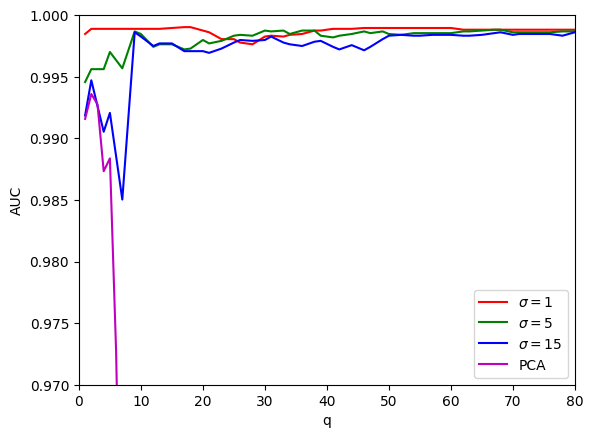

In [45]:
from sklearn import decomposition
fig, axs = plt.subplots(1,1)
num_params = num_search
sigmas = np.logspace(-2,2,num_params)
sigmas = np.array([1, 5, 15])
maxq = 80
qs = np.linspace(1,maxq,num_params,dtype = 'int')

gridsearch = np.zeros((len(sigmas)*len(qs),3)) #sigma, q, auc for each run
mesh = np.zeros((len(qs), len(sigmas)))

#perform gridsearch
run = 0
i= 0
for sigma in sigmas:
    j = 0
    for q in qs:
        model = kPCA(q = q, sigma = sigma)
        model.fit(x_train)
        val_scores = model.decision_function(x_val)
        auc = metrics.roc_auc_score(y_val,val_scores)
        gridsearch[run,:]= np.asarray([sigma,q,auc])
        mesh[j,i]=auc
        run += 1
        j += 1
    i += 1

# param_scatter(methods[1],fig,axs,gridsearch[:,0],gridsearch[:,1],'q',log=False)
idx = np.where(gridsearch[:,0] == sigmas[0])
axs.plot(gridsearch[idx,1].ravel(),gridsearch[idx,2].ravel(), color = 'r', label=r'$\sigma = {}$'.format(sigmas[0]))

idx = np.where(gridsearch[:,0] == sigmas[1])
axs.plot(gridsearch[idx,1].ravel(),gridsearch[idx,2].ravel(), color = 'g', label=r'$\sigma = {}$'.format(sigmas[1]))

idx = np.where(gridsearch[:,0] == sigmas[2])
axs.plot(gridsearch[idx,1].ravel(),gridsearch[idx,2].ravel(), color = 'b', label=r'$\sigma = {}$'.format(sigmas[2]))


maxq = 8
qs = np.linspace(1,maxq,num_params,dtype = 'int')
gridsearch = np.zeros((len(qs),2))

#perform gridsearch
run = 0


for q in qs:
    # model = PCA(q)
    # model.fit(x_train)
    # val_scores = model.decision_function(x_val)

    model = decomposition.PCA(n_components=q)
    model.fit(x_train)
    x_val_transformed = model.transform(x_val)
    val_scores = np.sum((model.inverse_transform(x_val_transformed) - x_val) ** 2, axis=1)

    auc = metrics.roc_auc_score(y_val,val_scores)
    gridsearch[run,:]= np.asarray([q,auc])
    run += 1

axs.plot(gridsearch[:,0].ravel(),gridsearch[:,1].ravel(), color = 'm',label = methods[1],ms=2)

axs.set_ylim([0.97, 1])
axs.set_xlim([0, 80])
axs.set_xlabel('q')
axs.set_ylabel('AUC')
axs.legend()
# fig, axs = plt.subplots(1,1)
# param_heatmap(methods[0],fig,axs,sigmas,qs,mesh,"sigma",'q',best_sigma,best_q,log=True)

# decision_boundary_plot(x_train, x_test, y_test, x_val, y_val, [model],methods[0])


## Fig 9

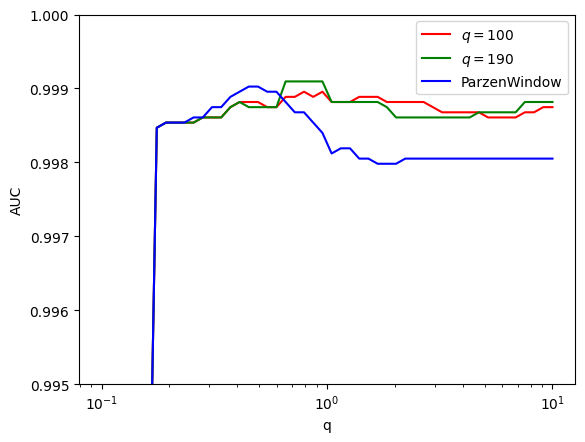

In [51]:
from sklearn import decomposition
models = []
scores = []
test_aucs = []
fig, axs = plt.subplots(1,1)
num_params = num_search
sigmas = np.logspace(-1,1,num_params)
# sigmas = np.array([1, 5, 15])
maxq = 80
# qs = np.linspace(1,maxq,num_params,dtype = 'int')
qs = np.array([100, 190])

gridsearch = np.zeros((len(sigmas)*len(qs),3)) #sigma, q, auc for each run
mesh = np.zeros((len(qs), len(sigmas)))

#perform gridsearch
run = 0
i= 0
for sigma in sigmas:
    j = 0
    for q in qs:
        model = kPCA(q = q, sigma = sigma)
        model.fit(x_train)
        val_scores = model.decision_function(x_val)
        auc = metrics.roc_auc_score(y_val,val_scores)
        gridsearch[run,:]= np.asarray([sigma,q,auc])
        mesh[j,i]=auc
        run += 1
        j += 1
    i += 1

# param_scatter(methods[1],fig,axs,gridsearch[:,0],gridsearch[:,1],'q',log=False)
idx = np.where(gridsearch[:,1] == qs[0])
axs.plot(gridsearch[idx,0].ravel(),gridsearch[idx,2].ravel(), color = 'r', label=r'$q = {}$'.format(qs[0]))

idx = np.where(gridsearch[:,1] == qs[1])
axs.plot(gridsearch[idx,0].ravel(),gridsearch[idx,2].ravel(), color = 'g', label=r'$q = {}$'.format(qs[1]))


#perform gridsearch
run = 0


gridsearch = np.zeros((len(sigmas),2))

#perform gridsearch
run = 0
for sigma in sigmas:
    model = kPCA(q = 0,sigma = sigma)
    model.fit(x_train)
    val_scores = model.decision_function(x_val)
    auc = metrics.roc_auc_score(y_val,val_scores)
    gridsearch[run,:]= np.asarray([sigma,auc])
    run += 1

axs.plot(gridsearch[:,0].ravel(),gridsearch[:,1].ravel(), color = 'b',label = methods[2],ms=2)
# axs.plot(gridsearch[:,0].ravel(),gridsearch[:,1].ravel(), color = 'm',label = methods[1],ms=2)
axs.set_xscale('log')
# plt.yticks(np.arange(0.965,1, 0.001))  # Adjust the step to a suitable interval
# plt.yticks(np.arange(0.9958, 0.9972, 0.0002))
# axs.yaxis.set_tick_params(size=5, width=1)  # Modify 'size' and 'width' as needed

axs.set_ylim([0.995, 1])
# axs.set_xlim([0.1, 10])
axs.set_xlabel('q')
axs.set_ylabel('AUC')
axs.legend()
# fig, axs = plt.subplots(1,1)
# param_heatmap(methods[0],fig,axs,sigmas,qs,mesh,"sigma",'q',best_sigma,best_q,log=True)

# decision_boundary_plot(x_train, x_test, y_test, x_val, y_val, [model],methods[0])

## Fig 8

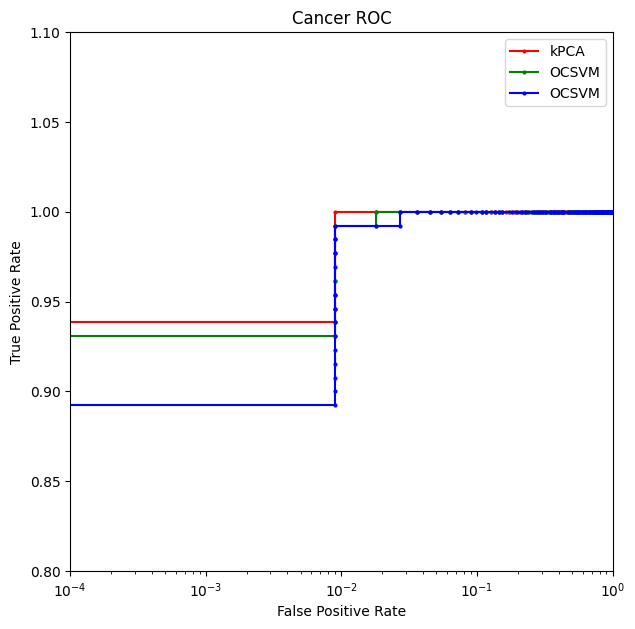

In [61]:
num_search = 150 # Number of Parameters to search in the given interval
models = []
scores = []
test_aucs = []

best_sigma = 2
best_q = 190
model = kPCA(q = int(best_q), sigma = best_sigma)
model.fit(x_train) #still using model data
test_scores = model.decision_function(x_test)
scores.append(test_scores)
test_auc = metrics.roc_auc_score(y_test,test_scores)
test_aucs.append(test_auc)
models.append(model)


sigma=1
gamma = 0.5/(sigma*sigma)
model = OCSVM(gamma = gamma)
model.fit(x_train) #still using model data
test_scores = model.decision_function(x_test)
scores.append(test_scores)
test_auc = metrics.roc_auc_score(y_test,test_scores)
test_aucs.append(test_auc)
models.append(model)


sigma=10
gamma = 0.5/(sigma*sigma)
model = OCSVM(gamma = gamma)
model.fit(x_train) #still using model data
test_scores = model.decision_function(x_test)
scores.append(test_scores)
test_auc = metrics.roc_auc_score(y_test,test_scores)
test_aucs.append(test_auc)
models.append(model)

# ROC Curve
key= 'Cancer'
methods = ['kPCA','OCSVM','OCSVM']
fig, ax = plt.subplots(figsize=(7,7))
colors = ['r','g','b']
for i in range(len(methods)):
    fpr,tpr,_ = metrics.roc_curve(y_test,scores[i],drop_intermediate = False)
    tpr[1] = 0
    if test_aucs[i] == 0.5:
        fpr = np.linspace(0,1,100)
        tpr = fpr
    ax.plot(fpr,tpr, color = colors[i], marker='o',label = methods[i],ms=2)
x=np.linspace(0,1,100)
y = x
# ax.plot(x,y,ls = "--",label='random')
ax.set_ylim([0.8, 1.1])
ax.set_xlim([1e-4,1])
ax.legend()
ax.set_title(key+' ROC')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xscale('log')